# Course project

This notebook includes the steps to optimize the capacity and dispatch of generators in a stylized energy system. It has been prepared to serve as a tutorial for a simple PyPSA model representing the energy system in one country, city or region. 
 

For the (optional) project of the course [Integrated Energy Grids](https://kurser.dtu.dk/course/2024-2025/46770?menulanguage=en) you need to deliver a report including the sections described at the end of this notebook.

Please, review the [PyPSA tutorial](https://martavp.github.io/integrated-energy-grids/intro-pypsa.html) before starting this project.

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install `pandas` and `pypsa` by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pandas pypsa
```
:::

In [47]:
import pandas as pd
import pypsa
import urllib3

urllib3.disable_warnings()

In [49]:
# Load Technology data
year = 2025
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0, 1])

costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>

We start by creating the network. In this example, the country is modelled as a single node, so the network includes only one bus.

We select the year 2015 and set the hours in that year as snapshots.

We select a country, in this case Denmark (DNK), and add one node (electricity bus) to the network.

In [23]:
network = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

network.set_snapshots(hours_in_2015.values)

network.add("Bus",
            "electricity bus")

network.snapshots

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2015-12-31 14:00:00', '2015-12-31 15:00:00',
               '2015-12-31 16:00:00', '2015-12-31 17:00:00',
               '2015-12-31 18:00:00', '2015-12-31 19:00:00',
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq=None)

The demand is represented by the historical electricity demand in 2015 with hourly resolution.

The file with historical hourly electricity demand for every European country is available in the data folder.

The electricity demand time series were obtained from ENTSOE through the very convenient compilation carried out by the Open Power System Data (OPSD). https://data.open-power-system-data.org/time_series/

In [24]:
# load electricity demand data
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime
country='IRL'
print(df_elec[country].head())

utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


In [25]:
# add load to the bus
network.add("Load",
            "load",
            bus="electricity bus",
            p_set=df_elec[country].values)

Index(['load'], dtype='object')

Print the load time series to check that it has been properly added (you should see numbers and not 'NaN')

In [26]:
network.loads_t.p_set

Load,load
snapshot,
2015-01-01 00:00:00,2651.0
2015-01-01 01:00:00,2412.0
2015-01-01 02:00:00,2256.0
2015-01-01 03:00:00,2170.0
2015-01-01 04:00:00,2136.0
...,...
2015-12-31 19:00:00,3728.0
2015-12-31 20:00:00,3461.0
2015-12-31 21:00:00,3195.0


In the optimization, we will minimize the annualized system costs.

We will need to annualize the cost of every generator, we build a function to do it.

In [27]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n


We include solar PV and onshore wind generators.

The capacity factors representing the availability of those generators for every European country can be downloaded from the following repositories (select 'optimal' for PV and onshore for wind).

https://zenodo.org/record/3253876#.XSiVOEdS8l0

https://zenodo.org/record/2613651#.XSiVOkdS8l0

We include also Open Cycle Gas Turbine (OCGT) generators

The cost assumed for the generators are the same as in Table 1 in the paper https://doi.org/10.1016/j.enconman.2019.111977 (open version:  https://arxiv.org/pdf/1906.06936.pdf)

In [ ]:
# add the different carriers, only gas emits CO2
network.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
network.add("Carrier", "onshorewind")
network.add("Carrier", "solar")

# add onshore wind generator
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
CF_wind = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_onshorewind = annuity(30,0.07)*910000*(1+0.033) # in €/MW
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind.values)

# add solar PV generator
df_solar = pd.read_csv('data/pv_optimal.csv', sep=';', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)
CF_solar = df_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_solar = annuity(25,0.07)*425000*(1+0.03) # in €/MW
network.add("Generator",
            "solar",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_solar,
            marginal_cost = 0,
            p_max_pu = CF_solar.values)

# add OCGT (Open Cycle Gas Turbine) generator
capital_cost_OCGT = annuity(25,0.07)*560000*(1+0.033) # in €/MW
fuel_cost = 21.6 # in €/MWh_th
efficiency = 0.39 # MWh_elec/MWh_th
marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "OCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_OCGT,
            marginal_cost = marginal_cost_OCGT)

# add Coal generator
capital_cost_coal= annuity(46,0.07)*3748080*(1+0.033) # in €/MW
fuel_cost = 46.1578 # in €/MWh_th
efficiency = 0.33 # MWh_elec/MWh_th
marginal_cost_coal = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "Coal",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="electricity",
            #p_nom_max=1000,
            capital_cost = capital_cost_coal,
            marginal_cost = marginal_cost_coal)

Index(['OCGT'], dtype='object')

Print the generator Capacity factor time series to check that it has been properly added (you should see numbers and not 'NaN')

In [29]:
network.generators_t.p_max_pu

Generator,onshorewind,solar
snapshot,,
2015-01-01 00:00:00,0.472,0.0
2015-01-01 01:00:00,0.435,0.0
2015-01-01 02:00:00,0.449,0.0
2015-01-01 03:00:00,0.524,0.0
2015-01-01 04:00:00,0.593,0.0
...,...,...
2015-12-31 19:00:00,0.156,0.0
2015-12-31 20:00:00,0.162,0.0
2015-12-31 21:00:00,0.155,0.0


We find the optimal solution using Gurobi as solver.

In this case, we are optimizing the installed capacity and dispatch of every generator to minimize the total system cost.

In [30]:
network.optimize(solver_name='gurobi')

Index(['electricity bus'], dtype='object', name='Bus')


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 32.25it/s]
INFO:linopy.io: Writing time: 0.42s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-8y7ce8vi.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-8y7ce8vi.lp


Reading time = 0.23 seconds


INFO:gurobipy:Reading time = 0.23 seconds


obj: 61323 rows, 26283 columns, 100743 nonzeros


INFO:gurobipy:obj: 61323 rows, 26283 columns, 100743 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 24.3.0 24D81)


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 24.3.0 24D81)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 61323 rows, 26283 columns and 100743 nonzeros


INFO:gurobipy:Optimize a model with 61323 rows, 26283 columns and 100743 nonzeros


Model fingerprint: 0xf3e7a96e


INFO:gurobipy:Model fingerprint: 0xf3e7a96e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [6e+01, 8e+04]


INFO:gurobipy:  Objective range  [6e+01, 8e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 5e+03]


INFO:gurobipy:  RHS range        [2e+03, 5e+03]


Presolve removed 35043 rows and 8760 columns


INFO:gurobipy:Presolve removed 35043 rows and 8760 columns


Presolve time: 0.08s


INFO:gurobipy:Presolve time: 0.08s


Presolved: 26280 rows, 17523 columns, 56940 nonzeros


INFO:gurobipy:Presolved: 26280 rows, 17523 columns, 56940 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 3


INFO:gurobipy: Dense cols : 3


 AA' NZ     : 3.942e+04


INFO:gurobipy: AA' NZ     : 3.942e+04


 Factor NZ  : 1.270e+05 (roughly 20 MB of memory)


INFO:gurobipy: Factor NZ  : 1.270e+05 (roughly 20 MB of memory)


 Factor Ops : 6.614e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.614e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.15447434e+10 -8.48336971e+10  4.77e+04 1.72e-13  5.02e+07     0s


INFO:gurobipy:   0   1.15447434e+10 -8.48336971e+10  4.77e+04 1.72e-13  5.02e+07     0s


   1   2.03050263e+10 -9.88957132e+10  4.87e+03 3.48e+02  8.48e+06     0s


INFO:gurobipy:   1   2.03050263e+10 -9.88957132e+10  4.87e+03 3.48e+02  8.48e+06     0s


   2   1.73881338e+10 -2.59487440e+10  5.46e-12 1.49e+00  7.85e+05     0s


INFO:gurobipy:   2   1.73881338e+10 -2.59487440e+10  5.46e-12 1.49e+00  7.85e+05     0s


   3   3.63668232e+09 -2.39185513e+09  5.46e-12 4.37e-10  1.07e+05     0s


INFO:gurobipy:   3   3.63668232e+09 -2.39185513e+09  5.46e-12 4.37e-10  1.07e+05     0s


   4   2.32752576e+09 -2.39907235e+08  3.64e-12 1.22e-09  4.52e+04     0s


INFO:gurobipy:   4   2.32752576e+09 -2.39907235e+08  3.64e-12 1.22e-09  4.52e+04     0s


   5   2.07765870e+09  1.32573681e+08  5.46e-12 1.31e-09  3.43e+04     0s


INFO:gurobipy:   5   2.07765870e+09  1.32573681e+08  5.46e-12 1.31e-09  3.43e+04     0s


   6   2.05725136e+09  2.36243026e+08  5.46e-12 5.82e-10  3.21e+04     0s


INFO:gurobipy:   6   2.05725136e+09  2.36243026e+08  5.46e-12 5.82e-10  3.21e+04     0s


   7   1.79639186e+09  9.07240101e+08  2.18e-11 1.46e-10  1.56e+04     0s


INFO:gurobipy:   7   1.79639186e+09  9.07240101e+08  2.18e-11 1.46e-10  1.56e+04     0s


   8   1.53814277e+09  1.05307307e+09  1.82e-11 7.57e-10  8.54e+03     0s


INFO:gurobipy:   8   1.53814277e+09  1.05307307e+09  1.82e-11 7.57e-10  8.54e+03     0s


   9   1.46401974e+09  1.15632383e+09  1.32e-11 2.91e-10  5.42e+03     0s


INFO:gurobipy:   9   1.46401974e+09  1.15632383e+09  1.32e-11 2.91e-10  5.42e+03     0s


  10   1.43085002e+09  1.21926628e+09  1.91e-11 3.20e-10  3.72e+03     0s


INFO:gurobipy:  10   1.43085002e+09  1.21926628e+09  1.91e-11 3.20e-10  3.72e+03     0s


  11   1.41544692e+09  1.25267613e+09  2.09e-11 1.28e-13  2.87e+03     0s


INFO:gurobipy:  11   1.41544692e+09  1.25267613e+09  2.09e-11 1.28e-13  2.87e+03     0s


  12   1.41024199e+09  1.29628406e+09  1.77e-11 1.16e-10  2.01e+03     0s


INFO:gurobipy:  12   1.41024199e+09  1.29628406e+09  1.77e-11 1.16e-10  2.01e+03     0s


  13   1.40191238e+09  1.33097573e+09  2.91e-11 8.73e-11  1.25e+03     0s


INFO:gurobipy:  13   1.40191238e+09  1.33097573e+09  2.91e-11 8.73e-11  1.25e+03     0s


  14   1.39760538e+09  1.34549033e+09  7.59e-11 2.91e-10  9.17e+02     0s


INFO:gurobipy:  14   1.39760538e+09  1.34549033e+09  7.59e-11 2.91e-10  9.17e+02     0s


  15   1.39508652e+09  1.35190392e+09  6.14e-11 1.64e-11  7.60e+02     0s


INFO:gurobipy:  15   1.39508652e+09  1.35190392e+09  6.14e-11 1.64e-11  7.60e+02     0s


  16   1.39413986e+09  1.35613843e+09  5.55e-11 1.27e-11  6.69e+02     0s


INFO:gurobipy:  16   1.39413986e+09  1.35613843e+09  5.55e-11 1.27e-11  6.69e+02     0s


  17   1.38961601e+09  1.36363998e+09  1.38e-10 2.62e-10  4.57e+02     0s


INFO:gurobipy:  17   1.38961601e+09  1.36363998e+09  1.38e-10 2.62e-10  4.57e+02     0s


  18   1.38806835e+09  1.36689514e+09  1.21e-10 1.46e-10  3.73e+02     0s


INFO:gurobipy:  18   1.38806835e+09  1.36689514e+09  1.21e-10 1.46e-10  3.73e+02     0s


  19   1.38764850e+09  1.36904283e+09  1.05e-10 6.40e-10  3.28e+02     0s


INFO:gurobipy:  19   1.38764850e+09  1.36904283e+09  1.05e-10 6.40e-10  3.28e+02     0s


  20   1.38739722e+09  1.37000282e+09  1.02e-10 7.57e-10  3.06e+02     0s


INFO:gurobipy:  20   1.38739722e+09  1.37000282e+09  1.02e-10 7.57e-10  3.06e+02     0s


  21   1.38696224e+09  1.37301762e+09  2.25e-10 2.55e-11  2.45e+02     0s


INFO:gurobipy:  21   1.38696224e+09  1.37301762e+09  2.25e-10 2.55e-11  2.45e+02     0s


  22   1.38544134e+09  1.37560669e+09  4.48e-10 3.46e-13  1.73e+02     1s


INFO:gurobipy:  22   1.38544134e+09  1.37560669e+09  4.48e-10 3.46e-13  1.73e+02     1s


  23   1.38498076e+09  1.37856647e+09  3.64e-10 2.62e-10  1.13e+02     1s


INFO:gurobipy:  23   1.38498076e+09  1.37856647e+09  3.64e-10 2.62e-10  1.13e+02     1s


  24   1.38467988e+09  1.38044863e+09  1.14e-09 5.24e-10  7.45e+01     1s


INFO:gurobipy:  24   1.38467988e+09  1.38044863e+09  1.14e-09 5.24e-10  7.45e+01     1s


  25   1.38462283e+09  1.38085571e+09  7.98e-10 4.66e-10  6.63e+01     1s


INFO:gurobipy:  25   1.38462283e+09  1.38085571e+09  7.98e-10 4.66e-10  6.63e+01     1s


  26   1.38454664e+09  1.38147886e+09  1.20e-09 4.37e-10  5.40e+01     1s


INFO:gurobipy:  26   1.38454664e+09  1.38147886e+09  1.20e-09 4.37e-10  5.40e+01     1s


  27   1.38449202e+09  1.38238557e+09  1.11e-09 8.73e-11  3.71e+01     1s


INFO:gurobipy:  27   1.38449202e+09  1.38238557e+09  1.11e-09 8.73e-11  3.71e+01     1s


  28   1.38447563e+09  1.38283909e+09  8.00e-10 2.56e-13  2.88e+01     1s


INFO:gurobipy:  28   1.38447563e+09  1.38283909e+09  8.00e-10 2.56e-13  2.88e+01     1s


  29   1.38447337e+09  1.38291600e+09  6.77e-10 5.82e-11  2.74e+01     1s


INFO:gurobipy:  29   1.38447337e+09  1.38291600e+09  6.77e-10 5.82e-11  2.74e+01     1s


  30   1.38446465e+09  1.38301844e+09  4.55e-10 4.07e-10  2.55e+01     1s


INFO:gurobipy:  30   1.38446465e+09  1.38301844e+09  4.55e-10 4.07e-10  2.55e+01     1s


  31   1.38445831e+09  1.38310931e+09  7.23e-10 1.73e-09  2.38e+01     1s


INFO:gurobipy:  31   1.38445831e+09  1.38310931e+09  7.23e-10 1.73e-09  2.38e+01     1s


  32   1.38445431e+09  1.38325985e+09  3.94e-10 3.62e-08  2.10e+01     1s


INFO:gurobipy:  32   1.38445431e+09  1.38325985e+09  3.94e-10 3.62e-08  2.10e+01     1s


  33   1.38445469e+09  1.38343721e+09  2.13e-09 2.49e-08  1.79e+01     1s


INFO:gurobipy:  33   1.38445469e+09  1.38343721e+09  2.13e-09 2.49e-08  1.79e+01     1s


  34   1.38445865e+09  1.38362432e+09  4.38e-09 4.37e-10  1.47e+01     1s


INFO:gurobipy:  34   1.38445865e+09  1.38362432e+09  4.38e-09 4.37e-10  1.47e+01     1s


  35   1.38444966e+09  1.38382613e+09  3.25e-09 2.91e-10  1.10e+01     1s


INFO:gurobipy:  35   1.38444966e+09  1.38382613e+09  3.25e-09 2.91e-10  1.10e+01     1s


  36   1.38444933e+09  1.38403484e+09  1.75e-09 4.07e-10  7.30e+00     1s


INFO:gurobipy:  36   1.38444933e+09  1.38403484e+09  1.75e-09 4.07e-10  7.30e+00     1s


  37   1.38444886e+09  1.38410563e+09  1.70e-09 2.33e-10  6.05e+00     1s


INFO:gurobipy:  37   1.38444886e+09  1.38410563e+09  1.70e-09 2.33e-10  6.05e+00     1s


  38   1.38444416e+09  1.38422341e+09  8.29e-09 5.82e-11  3.89e+00     1s


INFO:gurobipy:  38   1.38444416e+09  1.38422341e+09  8.29e-09 5.82e-11  3.89e+00     1s


  39   1.38444167e+09  1.38431949e+09  3.00e-09 1.40e-09  2.15e+00     1s


INFO:gurobipy:  39   1.38444167e+09  1.38431949e+09  3.00e-09 1.40e-09  2.15e+00     1s


  40   1.38444091e+09  1.38438607e+09  1.17e-09 7.11e-15  9.66e-01     1s


INFO:gurobipy:  40   1.38444091e+09  1.38438607e+09  1.17e-09 7.11e-15  9.66e-01     1s


  41   1.38444053e+09  1.38440931e+09  2.47e-09 2.91e-11  5.50e-01     1s


INFO:gurobipy:  41   1.38444053e+09  1.38440931e+09  2.47e-09 2.91e-11  5.50e-01     1s


  42   1.38444027e+09  1.38444024e+09  8.23e-08 1.46e-10  6.37e-04     1s


INFO:gurobipy:  42   1.38444027e+09  1.38444024e+09  8.23e-08 1.46e-10  6.37e-04     1s


  43   1.38444027e+09  1.38444027e+09  2.46e-10 2.38e-13  6.37e-07     1s


INFO:gurobipy:  43   1.38444027e+09  1.38444027e+09  2.46e-10 2.38e-13  6.37e-07     1s


  44   1.38444027e+09  1.38444027e+09  2.57e-11 2.07e-09  6.37e-10     1s


INFO:gurobipy:  44   1.38444027e+09  1.38444027e+09  2.57e-11 2.07e-09  6.37e-10     1s


INFO:gurobipy:


Barrier solved model in 44 iterations and 0.93 seconds (0.40 work units)


INFO:gurobipy:Barrier solved model in 44 iterations and 0.93 seconds (0.40 work units)


Optimal objective 1.38444027e+09


INFO:gurobipy:Optimal objective 1.38444027e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


       7 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       7 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


     957 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:     957 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.8335928e-09      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.8335928e-09      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


     967    1.3844403e+09   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:     967    1.3844403e+09   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 967 iterations and 1.03 seconds (0.42 work units)


INFO:gurobipy:Solved in 967 iterations and 1.03 seconds (0.42 work units)


Optimal objective  1.384440269e+09


INFO:gurobipy:Optimal objective  1.384440269e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 26283 primals, 61323 duals
Objective: 1.38e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

The message ('ok' , 'optimal") indicates that the optimizer has found an optimal solution.

The total cost can be read from the network objetive.

In [31]:
print(network.objective/1000000) #in 10^6 €

1384.4402689297674


The cost per MWh of electricity produced can also be calculated.

In [32]:
print(network.objective/network.loads_t.p.sum()) # EUR/MWh

Load
load    52.100949
dtype: float64


The optimal capacity for every generator can be shown.

In [33]:
network.generators.p_nom_opt # in MW

Generator
onshorewind    5932.735426
solar          1813.724333
OCGT           4423.874439
Name: p_nom_opt, dtype: float64

We can plot now the dispatch of every generator during the first week of the year and the electricity demand.
We import the matplotlib package which is very useful to plot results.

We can also plot the electricity mix.

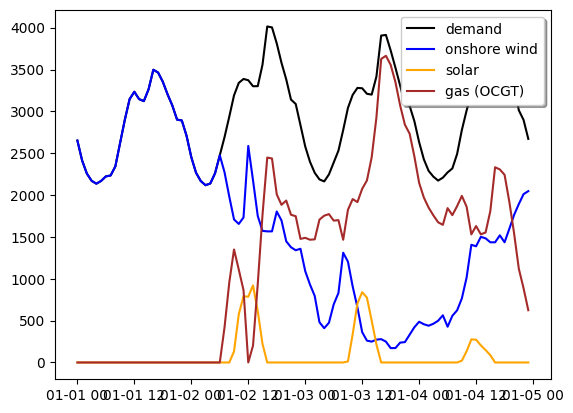

In [34]:
import matplotlib.pyplot as plt

plt.plot(network.loads_t.p['load'][0:96], color='black', label='demand')
plt.plot(network.generators_t.p['onshorewind'][0:96], color='blue', label='onshore wind')
plt.plot(network.generators_t.p['solar'][0:96], color='orange', label='solar')
plt.plot(network.generators_t.p['OCGT'][0:96], color='brown', label='gas (OCGT)')
plt.legend(fancybox=True, shadow=True, loc='best')

Text(0.5, 1.07, 'Electricity mix')

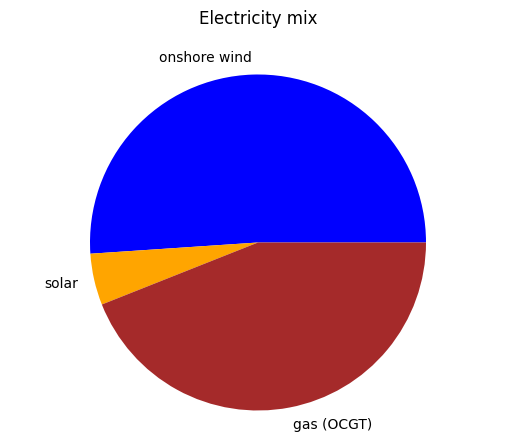

In [35]:
labels = ['onshore wind',
          'solar',
          'gas (OCGT)']
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['OCGT'].sum()]

colors=['blue', 'orange', 'brown']

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

We can add a global CO2 constraint and solve again.

In [36]:
co2_limit=1000000 #tonCO2
network.add("GlobalConstraint",
            "co2_limit",
            type="primary_energy",
            carrier_attribute="co2_emissions",
            sense="<=",
            constant=co2_limit)
network.optimize(solver_name='gurobi')

Index(['electricity bus'], dtype='object', name='Bus')


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 15.25it/s]
INFO:linopy.io: Writing time: 0.7s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-ydp90mkt.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-ydp90mkt.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 61324 rows, 26283 columns, 109503 nonzeros


INFO:gurobipy:obj: 61324 rows, 26283 columns, 109503 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 24.3.0 24D81)


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 24.3.0 24D81)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 61324 rows, 26283 columns and 109503 nonzeros


INFO:gurobipy:Optimize a model with 61324 rows, 26283 columns and 109503 nonzeros


Model fingerprint: 0x8d521efb


INFO:gurobipy:Model fingerprint: 0x8d521efb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [6e+01, 8e+04]


INFO:gurobipy:  Objective range  [6e+01, 8e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+06]


INFO:gurobipy:  RHS range        [2e+03, 1e+06]


Presolve removed 35043 rows and 8760 columns


INFO:gurobipy:Presolve removed 35043 rows and 8760 columns


Presolve time: 0.11s


INFO:gurobipy:Presolve time: 0.11s


Presolved: 26281 rows, 17523 columns, 65700 nonzeros


INFO:gurobipy:Presolved: 26281 rows, 17523 columns, 65700 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 3


INFO:gurobipy: Dense cols : 3


 AA' NZ     : 5.694e+04


INFO:gurobipy: AA' NZ     : 5.694e+04


 Factor NZ  : 1.534e+05 (roughly 20 MB of memory)


INFO:gurobipy: Factor NZ  : 1.534e+05 (roughly 20 MB of memory)


 Factor Ops : 9.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 9.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.85350291e+11 -9.34738817e+10  3.78e+07 8.62e-14  6.43e+08     0s


INFO:gurobipy:   0   1.85350291e+11 -9.34738817e+10  3.78e+07 8.62e-14  6.43e+08     0s


   1   3.16078150e+11 -1.25769319e+11  4.19e+06 2.19e+02  9.22e+07     0s


INFO:gurobipy:   1   3.16078150e+11 -1.25769319e+11  4.19e+06 2.19e+02  9.22e+07     0s


   2   2.23495167e+11 -1.15716590e+11  8.41e+04 7.57e-10  6.62e+06     0s


INFO:gurobipy:   2   2.23495167e+11 -1.15716590e+11  8.41e+04 7.57e-10  6.62e+06     0s


   3   5.04256516e+10 -4.53371401e+10  1.69e+04 8.54e-13  1.74e+06     0s


INFO:gurobipy:   3   5.04256516e+10 -4.53371401e+10  1.69e+04 8.54e-13  1.74e+06     0s


   4   1.95655262e+10 -2.15470677e+10  5.21e+03 1.31e-09  7.33e+05     0s


INFO:gurobipy:   4   1.95655262e+10 -2.15470677e+10  5.21e+03 1.31e-09  7.33e+05     0s


   5   8.64617390e+09 -8.74003027e+09  1.61e+03 6.98e-10  3.07e+05     0s


INFO:gurobipy:   5   8.64617390e+09 -8.74003027e+09  1.61e+03 6.98e-10  3.07e+05     0s


   6   6.27125292e+09 -4.02743491e+09  9.95e+02 7.86e-10  1.82e+05     0s


INFO:gurobipy:   6   6.27125292e+09 -4.02743491e+09  9.95e+02 7.86e-10  1.82e+05     0s


   7   4.86533967e+09 -3.38035000e+09  6.58e+02 1.72e-13  1.45e+05     0s


INFO:gurobipy:   7   4.86533967e+09 -3.38035000e+09  6.58e+02 1.72e-13  1.45e+05     0s


   8   4.01835127e+09 -2.74434865e+09  4.60e+02 3.49e-10  1.19e+05     0s


INFO:gurobipy:   8   4.01835127e+09 -2.74434865e+09  4.60e+02 3.49e-10  1.19e+05     0s


   9   3.65022149e+09 -2.25368013e+09  3.75e+02 4.07e-10  1.04e+05     0s


INFO:gurobipy:   9   3.65022149e+09 -2.25368013e+09  3.75e+02 4.07e-10  1.04e+05     0s


  10   3.34743390e+09 -1.37596382e+09  3.18e+02 1.75e-10  8.32e+04     0s


INFO:gurobipy:  10   3.34743390e+09 -1.37596382e+09  3.18e+02 1.75e-10  8.32e+04     0s


  11   2.96499801e+09 -5.29455755e+08  2.43e+02 2.91e-10  6.15e+04     0s


INFO:gurobipy:  11   2.96499801e+09 -5.29455755e+08  2.43e+02 2.91e-10  6.15e+04     0s


  12   2.85231761e+09  2.74858897e+08  2.16e+02 6.11e-10  4.54e+04     0s


INFO:gurobipy:  12   2.85231761e+09  2.74858897e+08  2.16e+02 6.11e-10  4.54e+04     0s


  13   2.55964833e+09  4.61345387e+08  1.64e+02 4.37e-10  3.69e+04     0s


INFO:gurobipy:  13   2.55964833e+09  4.61345387e+08  1.64e+02 4.37e-10  3.69e+04     0s


  14   2.27655326e+09  8.52994422e+08  1.12e+02 3.20e-10  2.51e+04     0s


INFO:gurobipy:  14   2.27655326e+09  8.52994422e+08  1.12e+02 3.20e-10  2.51e+04     0s


  15   2.11999743e+09  1.00582404e+09  7.96e+01 8.73e-11  1.96e+04     0s


INFO:gurobipy:  15   2.11999743e+09  1.00582404e+09  7.96e+01 8.73e-11  1.96e+04     0s


  16   2.03057079e+09  1.07459722e+09  6.07e+01 8.55e-11  1.68e+04     1s


INFO:gurobipy:  16   2.03057079e+09  1.07459722e+09  6.07e+01 8.55e-11  1.68e+04     1s


  17   1.99548063e+09  1.14923831e+09  5.19e+01 6.69e-10  1.49e+04     1s


INFO:gurobipy:  17   1.99548063e+09  1.14923831e+09  5.19e+01 6.69e-10  1.49e+04     1s


  18   1.96728047e+09  1.35550274e+09  4.64e+01 3.49e-10  1.08e+04     1s


INFO:gurobipy:  18   1.96728047e+09  1.35550274e+09  4.64e+01 3.49e-10  1.08e+04     1s


  19   1.87203843e+09  1.40171136e+09  2.67e+01 1.46e-11  8.27e+03     1s


INFO:gurobipy:  19   1.87203843e+09  1.40171136e+09  2.67e+01 1.46e-11  8.27e+03     1s


  20   1.84249706e+09  1.43173103e+09  1.98e+01 1.75e-10  7.22e+03     1s


INFO:gurobipy:  20   1.84249706e+09  1.43173103e+09  1.98e+01 1.75e-10  7.22e+03     1s


  21   1.81378951e+09  1.53417110e+09  1.39e+01 3.20e-10  4.92e+03     1s


INFO:gurobipy:  21   1.81378951e+09  1.53417110e+09  1.39e+01 3.20e-10  4.92e+03     1s


  22   1.79223035e+09  1.58762026e+09  8.77e+00 1.27e-11  3.60e+03     1s


INFO:gurobipy:  22   1.79223035e+09  1.58762026e+09  8.77e+00 1.27e-11  3.60e+03     1s


  23   1.77960095e+09  1.63052437e+09  6.53e+00 3.20e-10  2.62e+03     1s


INFO:gurobipy:  23   1.77960095e+09  1.63052437e+09  6.53e+00 3.20e-10  2.62e+03     1s


  24   1.76625288e+09  1.63935961e+09  4.09e+00 1.75e-10  2.23e+03     1s


INFO:gurobipy:  24   1.76625288e+09  1.63935961e+09  4.09e+00 1.75e-10  2.23e+03     1s


  25   1.75676849e+09  1.65208537e+09  2.33e+00 6.40e-10  1.84e+03     1s


INFO:gurobipy:  25   1.75676849e+09  1.65208537e+09  2.33e+00 6.40e-10  1.84e+03     1s


  26   1.74994832e+09  1.67844366e+09  1.26e+00 8.73e-11  1.26e+03     1s


INFO:gurobipy:  26   1.74994832e+09  1.67844366e+09  1.26e+00 8.73e-11  1.26e+03     1s


  27   1.74763426e+09  1.69232978e+09  9.29e-01 3.49e-10  9.72e+02     1s


INFO:gurobipy:  27   1.74763426e+09  1.69232978e+09  9.29e-01 3.49e-10  9.72e+02     1s


  28   1.74585256e+09  1.69660220e+09  6.92e-01 2.33e-10  8.65e+02     1s


INFO:gurobipy:  28   1.74585256e+09  1.69660220e+09  6.92e-01 2.33e-10  8.65e+02     1s


  29   1.74425387e+09  1.70028772e+09  4.88e-01 3.78e-10  7.72e+02     1s


INFO:gurobipy:  29   1.74425387e+09  1.70028772e+09  4.88e-01 3.78e-10  7.72e+02     1s


  30   1.74249314e+09  1.70947078e+09  2.77e-01 5.82e-10  5.80e+02     1s


INFO:gurobipy:  30   1.74249314e+09  1.70947078e+09  2.77e-01 5.82e-10  5.80e+02     1s


  31   1.74123068e+09  1.71475252e+09  1.41e-01 4.55e-11  4.65e+02     1s


INFO:gurobipy:  31   1.74123068e+09  1.71475252e+09  1.41e-01 4.55e-11  4.65e+02     1s


  32   1.73962912e+09  1.71777304e+09  1.02e-02 2.91e-11  3.84e+02     1s


INFO:gurobipy:  32   1.73962912e+09  1.71777304e+09  1.02e-02 2.91e-11  3.84e+02     1s


  33   1.73898176e+09  1.72475880e+09  5.48e-03 2.75e-14  2.50e+02     1s


INFO:gurobipy:  33   1.73898176e+09  1.72475880e+09  5.48e-03 2.75e-14  2.50e+02     1s


  34   1.73867941e+09  1.72712789e+09  3.91e-03 5.82e-11  2.03e+02     1s


INFO:gurobipy:  34   1.73867941e+09  1.72712789e+09  3.91e-03 5.82e-11  2.03e+02     1s


  35   1.73840091e+09  1.73069082e+09  2.30e-03 5.82e-10  1.35e+02     1s


INFO:gurobipy:  35   1.73840091e+09  1.73069082e+09  2.30e-03 5.82e-10  1.35e+02     1s


  36   1.73823483e+09  1.73245128e+09  1.39e-03 2.07e-10  1.02e+02     1s


INFO:gurobipy:  36   1.73823483e+09  1.73245128e+09  1.39e-03 2.07e-10  1.02e+02     1s


  37   1.73802903e+09  1.73374833e+09  3.39e-04 1.46e-10  7.52e+01     1s


INFO:gurobipy:  37   1.73802903e+09  1.73374833e+09  3.39e-04 1.46e-10  7.52e+01     1s


  38   1.73800377e+09  1.73422696e+09  2.53e-04 1.69e-10  6.63e+01     1s


INFO:gurobipy:  38   1.73800377e+09  1.73422696e+09  2.53e-04 1.69e-10  6.63e+01     1s


  39   1.73800081e+09  1.73516425e+09  2.12e-04 1.02e-09  4.98e+01     1s


INFO:gurobipy:  39   1.73800081e+09  1.73516425e+09  2.12e-04 1.02e-09  4.98e+01     1s


  40   1.73795377e+09  1.73608533e+09  7.61e-07 2.47e-10  3.28e+01     1s


INFO:gurobipy:  40   1.73795377e+09  1.73608533e+09  7.61e-07 2.47e-10  3.28e+01     1s


  41   1.73794030e+09  1.73675984e+09  3.98e-09 7.86e-10  2.07e+01     1s


INFO:gurobipy:  41   1.73794030e+09  1.73675984e+09  3.98e-09 7.86e-10  2.07e+01     1s


  42   1.73794685e+09  1.73789730e+09  3.64e-12 6.73e-11  8.70e-01     1s


INFO:gurobipy:  42   1.73794685e+09  1.73789730e+09  3.64e-12 6.73e-11  8.70e-01     1s


  43   1.73792906e+09  1.73792569e+09  3.64e-12 3.78e-10  5.92e-02     1s


INFO:gurobipy:  43   1.73792906e+09  1.73792569e+09  3.64e-12 3.78e-10  5.92e-02     1s


  44   1.73792882e+09  1.73792882e+09  3.64e-12 4.07e-10  1.55e-05     1s


INFO:gurobipy:  44   1.73792882e+09  1.73792882e+09  3.64e-12 4.07e-10  1.55e-05     1s


  45   1.73792882e+09  1.73792882e+09  8.01e-08 8.73e-10  2.42e-11     1s


INFO:gurobipy:  45   1.73792882e+09  1.73792882e+09  8.01e-08 8.73e-10  2.42e-11     1s


INFO:gurobipy:


Barrier solved model in 45 iterations and 1.13 seconds (0.44 work units)


INFO:gurobipy:Barrier solved model in 45 iterations and 1.13 seconds (0.44 work units)


Optimal objective 1.73792882e+09


INFO:gurobipy:Optimal objective 1.73792882e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


       3 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       3 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.25


INFO:gurobipy:


    3008 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:    3008 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.6122819e-09      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.6122819e-09      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    3014    1.7379288e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:    3014    1.7379288e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 3014 iterations and 1.51 seconds (0.98 work units)


INFO:gurobipy:Solved in 3014 iterations and 1.51 seconds (0.98 work units)


Optimal objective  1.737928819e+09


INFO:gurobipy:Optimal objective  1.737928819e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 26283 primals, 61324 duals
Objective: 1.74e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

In [37]:
network.generators.p_nom_opt #in MW

Generator
onshorewind    13391.552564
solar           5781.818900
OCGT            4326.909817
Name: p_nom_opt, dtype: float64

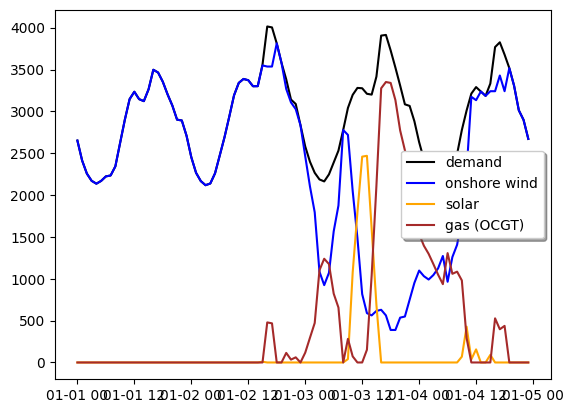

In [38]:
plt.plot(network.loads_t.p['load'][0:96], color='black', label='demand')
plt.plot(network.generators_t.p['onshorewind'][0:96], color='blue', label='onshore wind')
plt.plot(network.generators_t.p['solar'][0:96], color='orange', label='solar')
plt.plot(network.generators_t.p['OCGT'][0:96], color='brown', label='gas (OCGT)')
plt.legend(fancybox=True, shadow=True, loc='best')

Text(0.5, 1.07, 'Electricity mix')

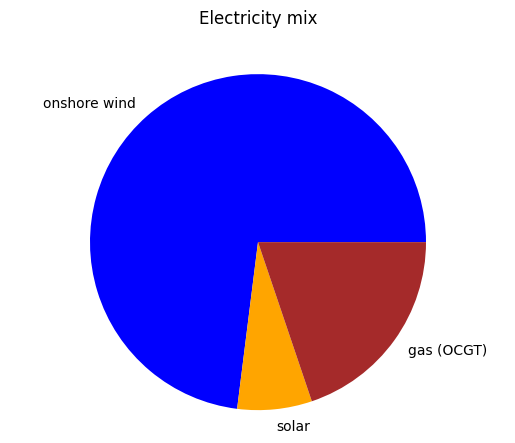

In [39]:
labels = ['onshore wind', 'solar', 'gas (OCGT)' ]
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['OCGT'].sum()]

colors = ['blue', 'orange', 'brown']

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

# PROJECT INSTRUCTIONS


Based on the previous example, you are asked to carry out the following tasks:

A. Choose a different country/region/city/system and calculate the optimal capacities for renewable and non-renewable generators. You can add as many technologies as you want. Remember to provide a reference for the cost assumptions. Plot the dispatch time series for a week in summer and winter. Plot the annual electricity mix. Use the duration curves or the capacity factor to investigate the contribution of different technologies.

B. Investigate how sensitive the optimum capacity mix is to the global CO2 constraint. E.g., plot the generation mix as a function of the CO2 constraint that you impose. Search for the CO2 emissions in your country (today or in 1990) and refer to the emissions allowance to that historical data.

C. Investigate how sensitive your results are to the interannual variability of solar and wind generation. Plot the average capacity and variability obtained for every generator using different weather years.

D. Add some storage technology/ies and investigate how they behave and what their impact is on the optimal system configuration. Discuss what strategies is your system using to balance the renewable generation at different time scales (intraday, seasonal, etc.)

E. Select one target for decarbonization (i.e., one CO2 allowance limit). What is the CO2 price required to achieve that decarbonization level? Search for information on the existing CO2 tax in your country (if any) and discuss your results.

F. Connect your country with, at least, two neighbouring countries. You can connect them using HVAC lines, HVDC links or gas pipelines. Use a linear representation of power flow or gas flow. 
You can assume that the generation capacities in the neighbouring countries are fixed or optimize the whole system. You can also include fixed interconnection capacities or optimize them with the generators' capacities. Discuss your results.

G. Connect the electricity sector with, at least, another sector( e.g. heating or transport), and co-optimize all the sectors. Discuss your results.

H. Finally, select one topic that is under discussion in your region. Design and implement some experiment to obtain relevant information regarding that topic. E.g.

- What are the consequences if Denmark decides not to install more onshore wind?

- Would it be more expensive if France decides to close its nuclear power plants?

- What will be the main impacts of the Viking link?

- How does gas scarcity impact the optimal system configuration?

**Write a short report (maximum length 10 pages) in groups of 4 students including your main findings.**

# Hints

_HINT 1: You can add a link with the following code_

The efficiency will be 1 if you are connecting two countries and different from one if, for example, you are connecting the electricity bus to the heating bus using a heat pump.
Setting p_min_pu=-1 makes the link reversible.


In [40]:
network.add("Link",
             'country a - country b',
             bus0="electricity bus country a",
             bus1="electricity bus country b",
             p_nom_extendable=True, # capacity is optimised
             p_min_pu=-1,
             length=600, # length (in km) between country a and country b
             capital_cost=400*600) # capital cost * length

Index(['country a - country b'], dtype='object')
Index(['country a - country b'], dtype='object')


Index(['country a - country b'], dtype='object')

_HINT 2: You can check the KKT multiplier associated with the constraint with the following code_

In [41]:
print(network.global_constraints.constant) # CO2 limit (constant in the constraint)
print(network.global_constraints.mu) # CO2 price (Lagrance multiplier in the constraint)

GlobalConstraint
co2_limit    1000000.0
Name: constant, dtype: float64
GlobalConstraint
co2_limit   -955.417743
Name: mu, dtype: float64


_HINT 3: You can add a H2 store connected to the electricity bus via an electrolyzer and a fuel cell with the following code_

In [42]:
#Create a new carrier
network.add("Carrier",
              "H2")

#Create a new bus
network.add("Bus",
          "H2",
          carrier = "H2")

#Connect the store to the bus
network.add("Store",
          "H2 Tank",
          bus = "H2",
          e_nom_extendable = True,
          e_cyclic = True,
          capital_cost = annuity(25, 0.07)*57000*(1+0.011))

#Add the link "H2 Electrolysis" that transport energy from the electricity bus (bus0) to the H2 bus (bus1)
#with 80% efficiency
network.add("Link",
          "H2 Electrolysis",
          bus0 = "electricity bus",
          bus1 = "H2",
          p_nom_extendable = True,
          efficiency = 0.8,
          capital_cost = annuity(25, 0.07)*600000*(1+0.05))

#Add the link "H2 Fuel Cell" that transports energy from the H2 bus (bus0) to the electricity bus (bus1)
#with 58% efficiency
network.add("Link",
          "H2 Fuel Cell",
          bus0 = "H2",
          bus1 = "electricity bus",
          p_nom_extendable = True,
          efficiency = 0.58,
          capital_cost = annuity(10, 0.07)*1300000*(1+0.05))


Index(['H2 Fuel Cell'], dtype='object')

_HINT 4: You can get inspiration for plotting the flows in the network in the following example_

https://pypsa.readthedocs.io/en/latest/examples/flow-plot.html